In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [3]:
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:

# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-9-1/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_10")

data_20_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-8-2/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_20")

[INFO] data\EUROSAT_10 directory exists, skipping download.
[INFO] data\EUROSAT_20 directory exists, skipping download.


In [5]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/EUROSAT_10/train'),
 WindowsPath('data/EUROSAT_20/train'),
 WindowsPath('data/EUROSAT_10/test'))

In [6]:
weights = torchvision.models.DenseNet201_Weights.DEFAULT
transforms = weights.transforms()
model = torchvision.models.densenet201(weights=weights)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
def create_denseNet_model(num_classes:int=10, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.DenseNet201_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.densenet201(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Linear(in_features=1920, out_features=num_classes)
  )

  return model, transforms

In [8]:

denseNet, denseNet_transforms = create_denseNet_model(num_classes=10,
                                                      seed=42)
denseNet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(denseNet, 
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [1, 3, 288, 288]     [1, 10]              --                   Partial
├─Sequential (features)                       [1, 3, 288, 288]     [1, 1920, 9, 9]      --                   False
│    └─Conv2d (conv0)                         [1, 3, 288, 288]     [1, 64, 144, 144]    (9,408)              False
│    └─BatchNorm2d (norm0)                    [1, 64, 144, 144]    [1, 64, 144, 144]    (128)                False
│    └─ReLU (relu0)                           [1, 64, 144, 144]    [1, 64, 144, 144]    --                   --
│    └─MaxPool2d (pool0)                      [1, 64, 144, 144]    [1, 64, 72, 72]      --                   --
│    └─_DenseBlock (denseblock1)              [1, 64, 72, 72]      [1, 256, 72, 72]     --                   False
│    │    └─_DenseLayer (denselayer1)         [1, 64, 72, 72]      [1, 32, 72, 7

In [10]:

# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_denseNet, test_dataloader_denseNet, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=denseNet_transforms,
                                                                                                 batch_size=32)

In [11]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=denseNet.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=denseNet,
                                train_dataloader=train_dataloader_denseNet,
                                test_dataloader=test_dataloader_denseNet,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4591 | train_acc: 0.8699 | test_loss: 0.2524 | test_acc: 0.9156
Epoch: 2 | train_loss: 0.2465 | train_acc: 0.9171 | test_loss: 0.2015 | test_acc: 0.9321
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9327 | test_loss: 0.1886 | test_acc: 0.9358
Epoch: 4 | train_loss: 0.1847 | train_acc: 0.9387 | test_loss: 0.1803 | test_acc: 0.9380
Epoch: 5 | train_loss: 0.1706 | train_acc: 0.9405 | test_loss: 0.1784 | test_acc: 0.9365
Epoch: 6 | train_loss: 0.1646 | train_acc: 0.9457 | test_loss: 0.1714 | test_acc: 0.9420
Epoch: 7 | train_loss: 0.1488 | train_acc: 0.9493 | test_loss: 0.1691 | test_acc: 0.9398
Epoch: 8 | train_loss: 0.1473 | train_acc: 0.9490 | test_loss: 0.1760 | test_acc: 0.9380
Epoch: 9 | train_loss: 0.1427 | train_acc: 0.9507 | test_loss: 0.1626 | test_acc: 0.9431
Epoch: 10 | train_loss: 0.1419 | train_acc: 0.9509 | test_loss: 0.1844 | test_acc: 0.9354


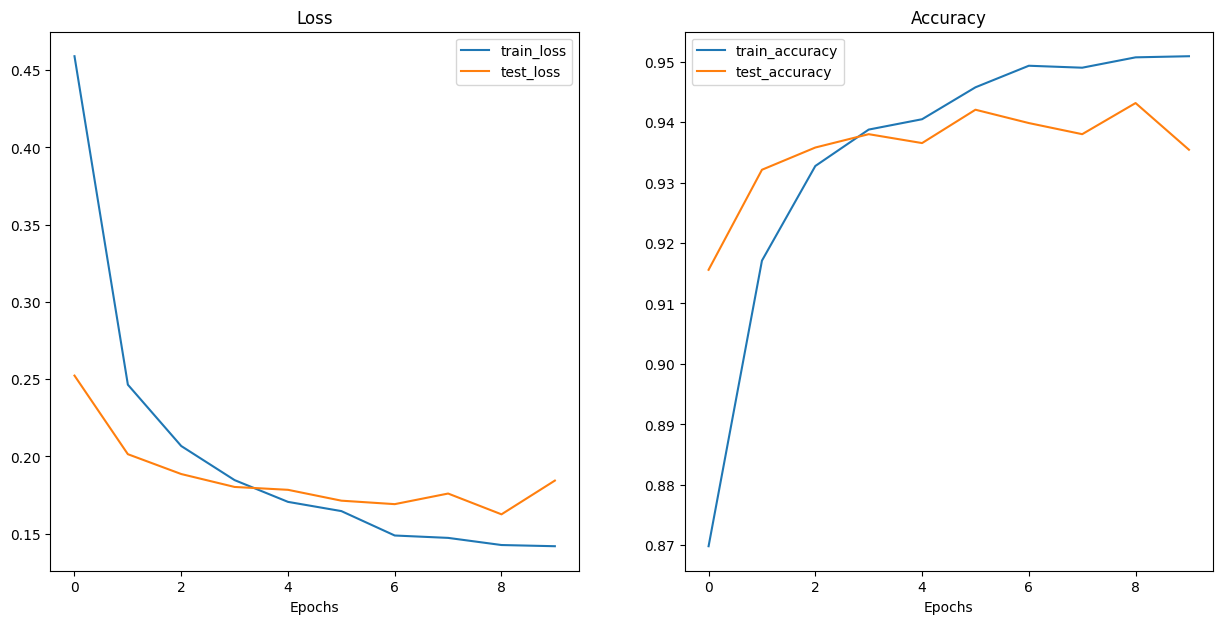

In [12]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [13]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=denseNet,
                 target_dir="models",
                 model_name="CNN_denseNet_Data_20_percent.pth")


[INFO] Saving model to: models\CNN_denseNet_Data_20_percent.pth
